In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

**A Carteira 8Fundos DEF é composta por:**

  * _7.5% Fidelity Global Cnsmr Inds A-Dis-EUR LU0114721508_
  * _7.5% GS Glb SmCp CORE® Eq E EUR Acc Close LU0245181838_
  * _7.5% M&G Optimal Income Euro A-H Acc GB00B1VMCY93_
  * _27.5% PIMCO GIS Global Bond E Acc EUR H IE00B11XZ103_
  
  
  * _7.5% MFS® Meridian Global Equity A1 EUR LU0094560744_
  * _7.5% Jupiter Dynamic Bond L EUR Acc LU0853555380_
  * _7.5% Invesco Global Smaller Coms Eq E EUR Acc LU0607512935_
  * _27.5% PIMCO GIS GlbInvGrdCrdt E EUR Hdg Acc IE00B11XZ434_

**A Carteira 8Fundos EW é composta por:**

  * _12.5% Fidelity Global Cnsmr Inds A-Dis-EUR LU0114721508_
  * _12.5% GS Glb SmCp CORE® Eq E EUR Acc Close LU0245181838_
  * _12.5% M&G Optimal Income Euro A-H Acc GB00B1VMCY93_
  * _12.5% PIMCO GIS Global Bond E Acc EUR H IE00B11XZ103_
  
  
  * _12.5% MFS® Meridian Global Equity A1 EUR LU0094560744_
  * _12.5% Jupiter Dynamic Bond L EUR Acc LU0853555380_
  * _12.5% Invesco Global Smaller Coms Eq E EUR Acc LU0607512935_
  * _12.5% PIMCO GIS GlbInvGrdCrdt E EUR Hdg Acc IE00B11XZ434_

**A Carteira 8Fundos AGR é composta por:**

  * _20% Fidelity Global Cnsmr Inds A-Dis-EUR LU0114721508_
  * _20% GS Glb SmCp CORE® Eq E EUR Acc Close LU0245181838_
  * _5% M&G Optimal Income Euro A-H Acc GB00B1VMCY93_
  * _5% PIMCO GIS Global Bond E Acc EUR H IE00B11XZ103_
  
  
  * _20% MFS® Meridian Global Equity A1 EUR LU0094560744_
  * _20% Jupiter Dynamic Bond L EUR Acc LU0853555380_
  * _5% Invesco Global Smaller Coms Eq E EUR Acc LU0607512935_
  * _5% PIMCO GIS GlbInvGrdCrdt E EUR Hdg Acc IE00B11XZ434_

In [2]:
# importing libraries
#import monthly_returns_heatmap as mrh
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import seaborn as sns
import cufflinks as cf
import pandas as pd
import numpy as np
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pandas.core.base import PandasObject
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

#Set seaborn style
#sns.set_style("whitegrid")

# Set cufflinks offline
cf.go_offline()

In [3]:
#### Functions ####
def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min().abs()

def compute_cagr(dataframe, years=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)

def compute_romad(dataframe):
    '''
    Function to calculate RoMaD: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_performance_table(dataframe, years='si', freq='days'):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.    
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365.25
        
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD']
        return round(df, 2)        
    
    else:
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD']
        return round(df, 2)

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = fundos.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
def get(quotes):

    # resample quotes to business month
    monthly_quotes = quotes.resample('BM').last()
    
    # get monthly returns
    returns = monthly_quotes.pct_change()

    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plot(returns,
         title="Monthly Returns (%)",
         title_color="black",
         title_size=12,
         annot_size=10,
         figsize=None,
         cmap='RdYlGn',
         cbar=True,
         square=False):

    returns = get(returns)
    returns *= 100
    
    if figsize is None:
        size = list(plt.gcf().get_size_inches())
        figsize = (size[0], size[0] // 2)
        plt.close()

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(returns, ax=ax, annot=True,
                     annot_kws={"size": annot_size}, fmt="0.2f", linewidths=0.4, center=0,
                     square=square, cbar=cbar, cmap=cmap)
    ax.set_title(title, fontsize=title_size, color=title_color, fontweight="bold")

    fig.subplots_adjust(hspace=0)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()


PandasObject.get_returns_heatmap = get
PandasObject.plot_returns_heatmap = plot

In [4]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2019-05-05 23:51:21


In [5]:
Corr_matrix = pd.read_csv('Corr_Matrix.csv', index_col='Unnamed: 0')

### Matrix de correlação dos retornos dos fundos

Em baixo vemos a matriz de correlaçaõ dos retornos dos fundos. Vemos facilmente _"blocos"_ com uma correlação elevada entre os fundos acionistas, que por sua vez não têm qualquer correlação com os fundos obrigacionistas. O oposto também se pode ver, embra a correlação entre o Pimco GB e o MG_OI não seja assim tão alta, fruto da maior flexibilidade que o gestor do MG_OI tem em seu dispôr.

A existência de fundos descorrelacionados ou com baixa correlação é provavelmente a melhor situação realista, e contribui bastante para a construção de uma boa carteira.

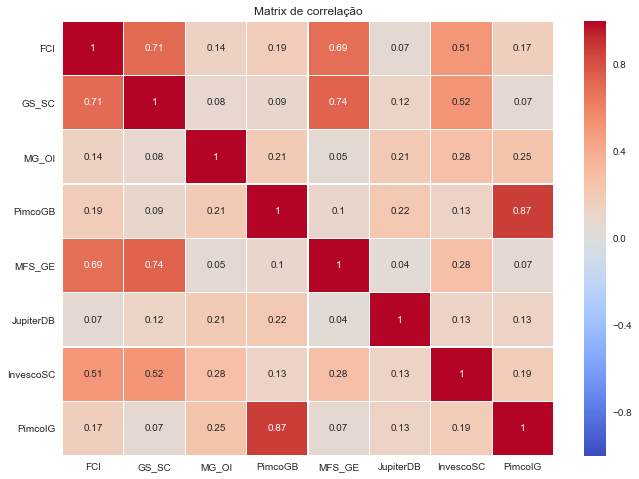

In [6]:
# Correlation Matrix
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

sns.heatmap(Corr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin = -1)
plt.yticks(rotation=360)
plt.title('Matrix de correlação')
plt.show()

In [7]:
fundos = pd.read_csv('Portfolios.csv', sep=',',  index_col='Unnamed: 0', parse_dates=True)

In [8]:
#fundos.tail()

In [9]:
#### Normalization to 100 ####
fundos_norm = round((fundos.div(fundos.iloc[0]).mul(100)), 2)

#### Returns ####
P_returns = fundos_norm.pct_change()

### Gráficos de performance

Antes de chegarmos à tabelas e ao pormenor de análise de risco, sou apologista que um gráfico vale por 1000 palavras e apresento o gráfico de evolução da carteira. 

Penso que o que está imediatamente abaixo é de simples compreensão. É aquilo a que estamos habituamos a ver mais. A evolução dos investimentos em cada fundo. Neste caso estão normalizados a 100. Esta é a evolução ao longo dos anos de cada 100 euros investidos.

**Dica:** A interactividade dos gráficos da plotly permite:

    . Zoom (mantenham o clique e arrastem o cursor em simultâneo, em cima do gráfico);
    . Tem uma lista de opções que aparece se forem com o cursor ao canto superior direito;
    . Façam duplo clique no gráfico ou seleccionem a opção Autoscale/Reset Axes para voltar ao normal;
    . Alterem a opção de 'Compare data on hoover' para 'Show closest data on hoover' se vos for mais conveniente;
    . Se clicarem num nome na legenda esse fundo desaparece (clicando de novo ele volta a apetecer).

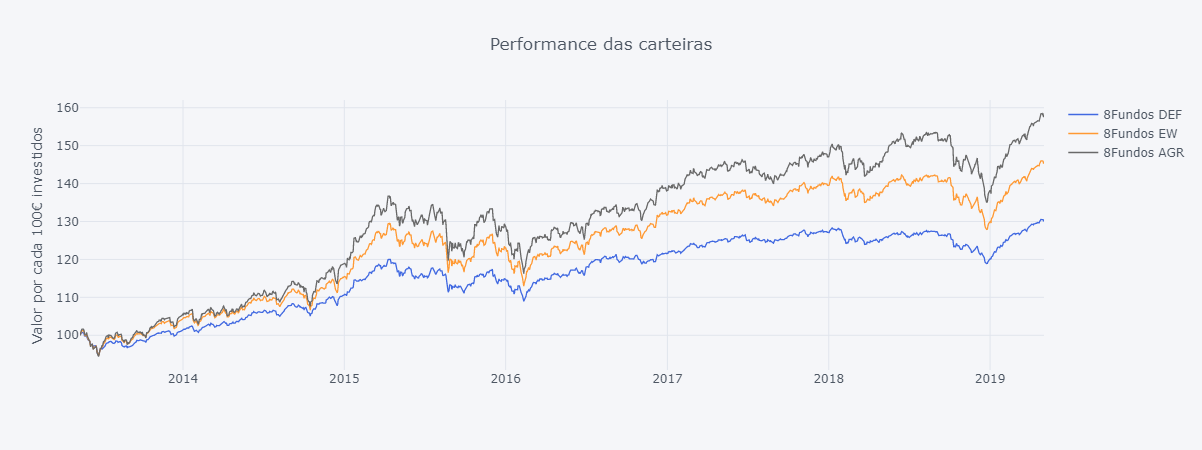

In [10]:
fundos_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos',
                  title='Performance das carteiras', colors=['royalblue', 'orange', 'dimgray'])

O segundo gráfico é um gráfico em escala logaritmica. Porque um gráfico de escala logaritmica? Um gráfico de escala logaritmica é um gráfico onde o espaço visual é medido em percentagem, e não em euros. Ou seja, o problema dos gráficos de longo prazo  é que à medida que a carteira sobe uma variação de 5 euros, deixa de ser uma variação de 5% mas de apenas 2%. Isso faz com que as variações mais antigas pareçam pequenas e amplia as mais recentes.

Para colmatar isso o gráfico com escala logaritmica mostra o mesmo espaço entre 100 e 105 como mostra entre 200 e 210, pois afinal são ambas variações de 5%. Isso acaba por torar um gráfico de longo prazo mais realista. Apercebem-se como  a crise de 2008 parece mais volátil no gráficode escala logaritmica e as recentes subidas mais pequenas? Esse é o objectivo e uma consequência de medição das variações em termos relativos (percentuais) em vez de absolutos (por montante de euros).

In [11]:
#fundos_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos',  title='Performance das carteiras com regressão linear',
 #                 bestfit=True)

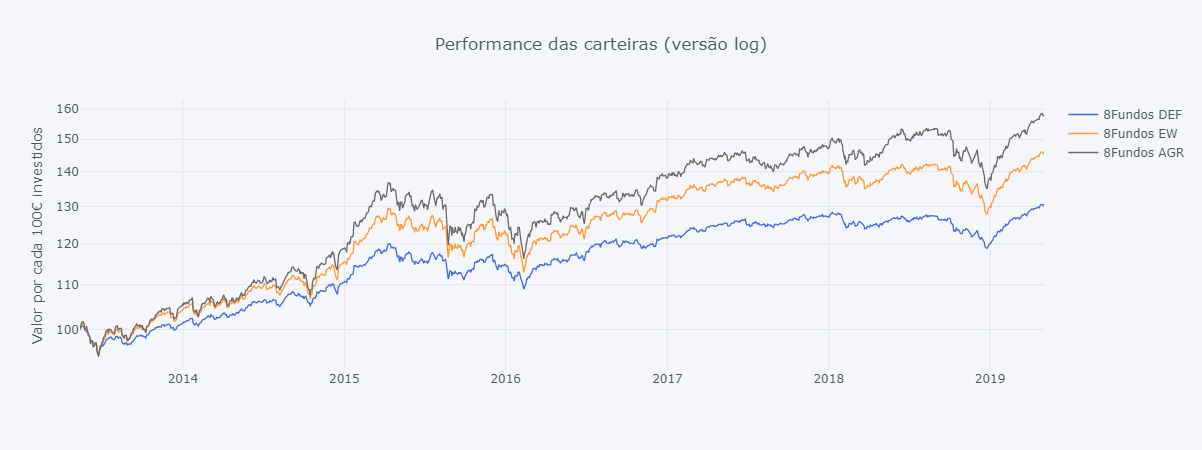

In [12]:
fundos_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos',
                  title='Performance das carteiras (versão log)', logy=True, colors=['royalblue', 'orange', 'dimgray'])

Este último gráfico pode ser incrivelmente simples, para quem já o viu,  ou complexo para quem não sabe o conceito de drawdown.  Drawdown é o conceito ficenanceiro que resumidamente pode-se referir como _"quedas a partir do máximo"_. Este é um conceito muito importante e mostra os valores percentuais que a carteira está do seus máximos históricos. Responde à pergunta, se eu tivesse comprado no pico quanto estaria agora a perder?

Esclareço, contudo, que há diferentes picos, como seria de esperar numa carteira que se encontre em ascensão. Sempre que o drawdown atinge 0 é sinal que fez um novo pico (ou igualou o anterior), pois, por definição, uma carteira nunca poderá estar acima do seu máximo histórico.

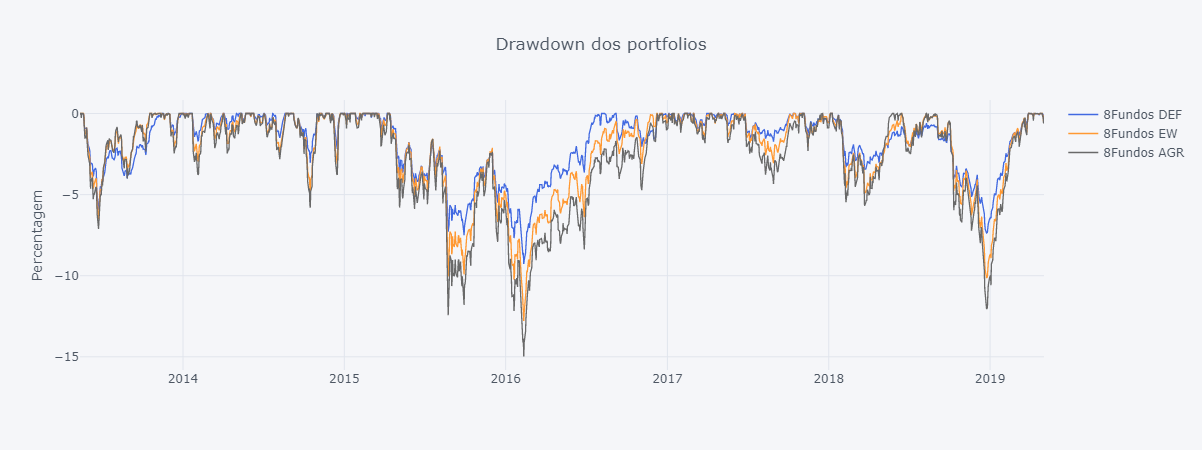

In [13]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(fundos_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem', colors=['royalblue', 'orange', 'dimgray'])

##### Valores actuais do drawdown

In [14]:
DD.tail(1)

8Fundos DEF  8Fundos EW  8Fundos AGR
2019-05-03        -0.15       -0.21        -0.26

In [15]:
#### Returns ####
returns = (fundos_norm / fundos_norm.shift(1)) - 1

# Resampling to yearly (business year)
yearly_quotes = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year)
yearly_quotes = pd.concat([fundos_norm.iloc[:1], yearly_quotes])

### Tabela de Performance desde 2007-04-23 (início do backtest)

Esta é a tabela de performance desde o início do backtest. O CAGR diz-nos a rentabilidade anualizada ao longo do período e o StdDev diz-nos a volatilidade anualizada. 

O retorno foi maior quanto maior foi o risco da carteira. Algo que poderá nem sempre acontecer, especialmente em espaços curtos de tempo. Mas neste caso, em em linha com as teorias financeiras temos um retorno maior pelo risco assumido.

Algo que é independente do período é as carteiras com mais risco apresentarem, de facto um maior desvio padrão. Ou seja, quanto mais agressiva a carteira maior o seu risco, naturalmente. Temos é uma visão mais quantitativa desse risco. O desvio padrão não é a única forma de medir risco mas é bastante comum e importante.

Para comparação entre as carteiras temos também o rácio de Sharpe. Neste caso um simples rácio CAGR/StdDev. Quanto mais alto melhor, pois ele mede a rentabilidade por cada unidade de risco. Quando falamos de rentabilidades relativamente baixas um pequeno aumento de risco aaba por se transformar num equivalente bom aumento de rentabilidade. Contudo, em rentabilidades mais elevadas para aumentar um pouco mais a rentabilidade teremos de aumentar significativamente o risco. Daí as carteiras com maior risco normalmente terem um menor Sharpe. O aumento de risco para ter mais um pouco de rentabilidade tem de ser significativo.

Outra forma de medir o risco pode ser pela maior queda que a carteira já teve. Este acaba por ser uma medida de risco a que eu pessoalmente acabo por dar maior importância. É efectivamente o que nos cria stress e pode levar à vontade de vender a carteira nos momentos mais inoportunos. Termos uma boa ideia de quanto  aguentamos em drawdown máximo é algo importante  para conseguirmos ter o conforto de manter os investimentos a médio/longo prazo.

In [16]:
compute_performance_table(fundos)

8Fundos DEF  8Fundos EW  8Fundos AGR
CAGR           4.54        6.50         7.97
StdDev         3.94        5.95         7.86
Sharpe         1.15        1.09         1.01
Max DD         9.28       12.80        14.98

### Retornos anuais e mensais das carteiras

Podemos ver, em baixo, quadros com os respectivos retornos anuais e mensais de cada carteira. É possível quantificar a queda em 2008, e mais especificamente o período de falência da lehman brothers (olhando para o quadro mensal) , onde até a carteira defensiva teve uma queda significativa. De igual forma conseguimos ver a rápida e forte recuperação e consequente continuação da subida desde a crise.

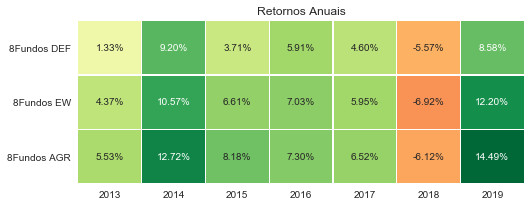

In [18]:
# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
yearly_returns = yearly_returns.set_index([list(range(2012, 2020))]).drop(2012)

#### Inverter o sentido das rows no dataframe ####
yearly_returns = yearly_returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(8, 3) # 68%
heatmap = sns.heatmap(yearly_returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=0)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Retornos Anuais')
plt.yticks(rotation=360)
plt.show()

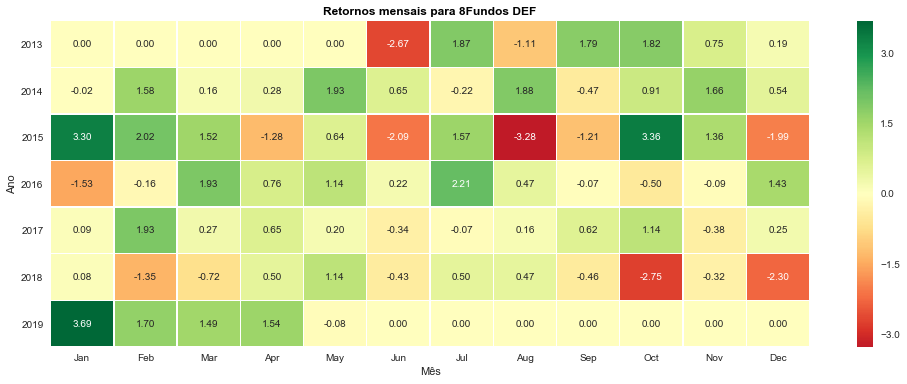

In [19]:
plot(fundos_norm['8Fundos DEF'], title= 'Retornos mensais para 8Fundos DEF', figsize=(17,6))

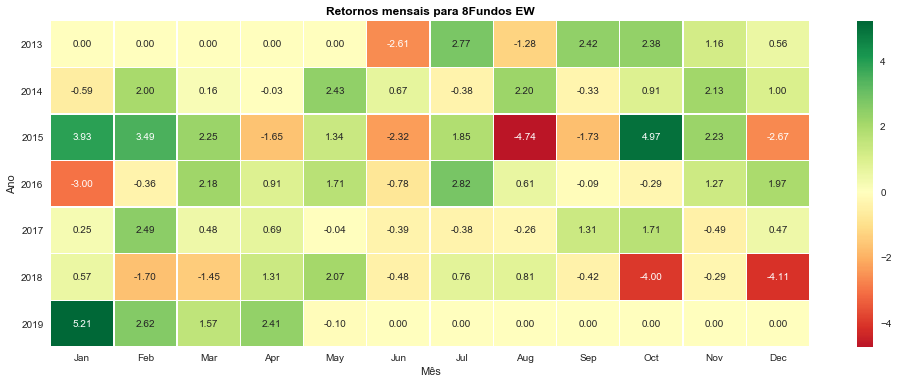

In [20]:
plot(fundos_norm['8Fundos EW'], title= 'Retornos mensais para 8Fundos EW', figsize=(17,6))

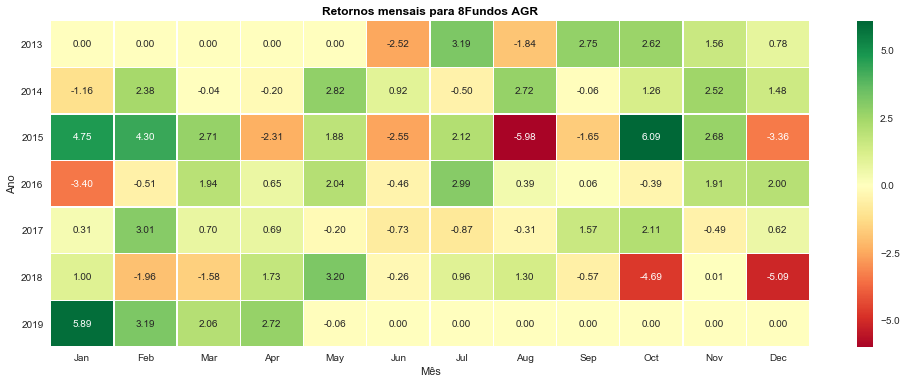

In [21]:
plot(fundos_norm['8Fundos AGR'], title= 'Retornos mensais para 8Fundos AGR', figsize=(17,6))

##### Sumário de estatísticas para os retornos mensais

O sumário de estatísticas para os retornos mensais, assim como respectivos gráficos de boxplot e swarmplot, mostra o que poderemos esperar de uma variação mensal. Podemos ver não só a variação mensal máxima como a mínima de cada carteira, assim como a variação mediana.

In [ ]:
# Turning daily quotes into monthly
fundos_norm_M = fundos_norm.resample('BM').last()
# Monthly returns
fundos_norm_ret_M = fundos_norm_M.pct_change() *100

fundos_norm_ret_M.describe().iloc[[1, 3, 4, 5, 6, 7],:]

#### Boxplot de retornos mensais para as diferentes carteiras

No boxplot podemos ver bem a parte central da vela (que tem 50% das variações) a ter de aumentar consoante o risco da carteira. Enquanto a carteira defensiva tem 50% das variações mensais compreendidas entre -0.23 e 1.47 a agressiva, por força da sua maior volatilidade, já tem de aumentar o intervalo, indo de -0.78 até 2.62.

As barras do boxplot vão até onde faz sentido para albergar praticamente todas as variações, pois apenas excluir os valores extremos (outliers). Isso é mais visível no swarmplot.

In [ ]:
my_pal = ["royalblue", "orange", "dimgrey"]

plt.figure(figsize=(7, 6), dpi=80)
my_pal = ["royalblue", "orange", "dimgrey"]
ax = sns.boxplot(data=fundos_norm_ret_M, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot das rentabilidades mensais (com outliers)")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação')
plt.show()

A leitura do swarmplot é semelhante à do boxplot mas com a pequena distinção que conseguimos visualizar a quantidade de pontos (cada uma a representar uma variação mensal).  Como esperado as observações encontram-se concentradas perto da mediana e ao longo do já falado corpo principal da vela do boxplot. Neste gráfico são bastante visíveis os outliers, e como estão distanciados do comportamento normal das carteiras.

In [ ]:
ax = sns.swarmplot(data=fundos_norm_ret_M, orient='v', linewidth=1,  palette=my_pal)
ax.set_title("Swarmplot das rentabilidades mensais")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação')
plt.show()

In [ ]:
# Importar os .csv das tabelas de drawdowns
DD_DEF = pd.read_csv('DD_DEF.csv', sep=',',  index_col='Unnamed: 0')
DD_EW  = pd.read_csv('DD_EW.csv' , sep=',',  index_col='Unnamed: 0')
DD_AGR = pd.read_csv('DD_AGR.csv', sep=',',  index_col='Unnamed: 0')

### Tabelas de drawdowns

As tabelas de drawdowns são bastante úteis, pois podemos visualizar as quedas em toda a sua dimensão, quer em termos de profundidade como tempo. Os quadros incluem várias métricas, mas alerto que os periodos estão em sessões, não em dias. Cada ano tem cerca de 260 sessões, no nosso caso, daí o periodo de 2007-06-04 a 2009-03-09 (mais de 2 anos) só incluir "613" sessões e não mais de 800 como seria de esperar se fossem em dias.

Podemos aqui rápidamente quantificar o gráfico dos drawdown acima e ver a profundidade e tempo das 5 maiores quedas de cada carteira. Naturalmente quanto mais risco tem a carteira não só tem quedas mais profundas como demora mais tempo a voltar a atingir novos máximos históricos.

##### Tabela de Drawdowns da 4Fundos Defensiva

In [ ]:
DD_DEF

##### Tabela de Drawdowns da 4Fundos Equal Weight

In [ ]:
DD_EW

##### Tabela de Drawdowns da 4Fundos Agressiva

In [ ]:
DD_AGR

### Histogramas de drawdowns das carteiras

Os 3 gráficos abaixo mostram, para cada carteira, quanto tempo ela passou abaixo de determinado drawdown. Como já visto acima a carteira defensiva tem um drawdown menor que a moderada ou agressiva, sendo isso visivel pelo valor mais à direita na escala do x. Da mesma forma, é de esperar que tenha passado menos tempo abaixo de um determinado drawdown, pois quanto mais agressiva uma carteira maiores as quedas mas também mais tempo se passa em valores longe dos máximos, algo é fruto dessas mesmas quedas.

Escolhendo arbitrariamente um valor de 5% podemos ver que a carteira defensiva passou 16.76% do tempo em que estava a 5% ou mais do seu máximo histórico.  Por seu lado, e em linha com as nossas espectativas a carteira moderada passou mais tempo com um drawdown igual ou superior a 5%, neste caso 31.82%. Por último a carteira agressiva passou 43.26% do seu tempo em que se encontrava pelo menos a 5% do seu máximo histórico.

O tempo, que se passa longe dos máximos históricos é psicológicamente desgastantante, e uma clara alusão à capacidade de cada um de nós de aguentar perdas, quer em profundidade como em dimensão.

À pessoa mais curiosa deixo a tarefa de fazer o oposto. Será natural a carteira com menos risco passar mais tempo com uma queda inferior 1%. Podem por vocês mesmos verificar isso, que é exactamente o que acontece.

In [ ]:
layout = go.Layout(
    title='Histograma dos drawdowns da 8Fundos DEF',
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    xaxis=dict(
        title='Drawdown',
        showgrid=True,
    ),
    yaxis=dict(
        title='Percentagem de tempo abaixo de um dado drawdown'
    ))
data = [go.Histogram(x=DD['8Fundos DEF'], histnorm='percent', marker=dict(colorscale='RdBu', cmax= -25, cmin=-1, color=np.arange(-20, 0),
                                                                          line=dict(color='white', width=0.2)), opacity=0.75, cumulative=dict(enabled=True))]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
layout = go.Layout(
    title='Histograma dos drawdowns da 8Fundos EW',
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    xaxis=dict(
        title='Drawdown',
        showgrid=True,
    ),
    yaxis=dict(
        title='Percentagem de tempo abaixo de um dado drawdown'
    ))
data = [go.Histogram(x=DD['8Fundos EW'], histnorm='percent', marker=dict(colorscale='RdBu', cmax= -25, cmin=-1, color=np.arange(-27, 0),
                                                                            line=dict(color='white', width=0.2)), opacity=0.75, cumulative=dict(enabled=True))]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
layout = go.Layout(
    title='Histograma dos drawdowns da 8Fundos AGR',
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    xaxis=dict(
        title='Drawdown',
        showgrid=True,
    ),
    yaxis=dict(
        title='Percentagem de tempo abaixo de um dado drawdown'
    ))
data = [go.Histogram(x=DD['8Fundos AGR'], histnorm='percent', marker=dict(colorscale='RdBu', cmax= -25, cmin=-1, color=np.arange(-31, 0),
                                                                            line=dict(color='white', width=0.2)), opacity=0.75, cumulative=dict(enabled=True))]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Tabelas de Performance

Em baixo podemos ver várias tabelas de performance para periodos compreendidos entre 1 e 3 anos. Podemos assim ver qual a rentabilidade anualizada em diferentes periodos, assim como o desvio padrão e a maior queda nesse periodo. O sharpe, como já referido acima, é um bom comparador para ver a qualidade das carteiras.

Em baixo de cada tabela podemos ver os gráficos da evolução da carteira, para termos uma noção visual da evolução no periodo em causa.

##### Tabela de performance a 1 ano

In [ ]:
# One year dataframe for portfolios
one_year_df = filter_by_date(fundos, years=1)
compute_performance_table(one_year_df, years=1)

In [ ]:
# Normalization to 100
one_year_df_norm = round((one_year_df.div(one_year_df.iloc[0]).mul(100)), 2)
# Plotting
one_year_df_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Gráfico de performance das carteiras a 1 ano', colors=['royalblue', 'orange', 'dimgray'])

##### Tabela de performance a 3 anos

In [ ]:
# Three years dataframe for portfolios
three_years_df = filter_by_date(fundos, years=3)
compute_performance_table(three_years_df, years=3)

In [ ]:
# Normalization to 100
three_years_df_norm = round((three_years_df.div(three_years_df.iloc[0]).mul(100)), 2)
# Plotting
three_years_df_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos',
                                                 title='Gráfico de performance das carteiras a 3 anos', colors=['royalblue', 'orange', 'dimgray'])

In [ ]:
# Importing .CSV of rolling returns per year
one_year_rolling    = pd.read_csv('one_year_rolling.csv', sep=',',  index_col='Unnamed: 0', parse_dates=True)
three_years_rolling = pd.read_csv('three_years_rolling.csv', sep=',',  index_col='Unnamed: 0', parse_dates=True)

### Retornos rolantes por período

Os retornos rolantes são gráficos muito interessantes, pois mostram-nos, de forma continua, a rentabilidade para determinado periodo que cada carteira teve. Podemos ver, por exemplo, que a carteira agressiva chegou a ter uma rentabilidade de 56% quando foi da recuperação da cride 2008. Por outro lado, no mesmo periodo a carteira defensiva "só" subiu 36%, o que é natural dada a estrutura defensiva da mesma. 

##### Retornos rolantes a 1 ano

In [ ]:
one_year_rolling.iplot(kind='scatter', title='Retornos rolantes a 1 ano', yTitle='Percentagem da variação dos retornos a 1 ano', colors=['royalblue', 'orange', 'dimgray'])

Para reforçar a ideia que tentei mostrar acima, de que quanto maior o risco maior a variabilidade dos retornos temos também este boxplot. O boxplot dá uma visão diferente mas em linha com essa ideia.

Facilmente podemos ver que a barra/boxplot referente à carteira defensiva teve uma menor amplite do que a referente à carteira EW. Os pontos positivos e negativos das carteiras com mais risco são significamente mais extremos do que os da carteira defensiva.

In [ ]:
my_pal = ["royalblue", "orange", "dimgrey", 'indigo']

plt.figure(figsize=(7, 6), dpi=80)
ax = sns.boxplot(data=one_year_rolling, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot dos retornos rolantes a 1 ano (com outliers)")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação dos retornos a 1 ano')
plt.show()

##### Retornos rolantes a 3 anos

Quando começamos a analisar retornos rolantes a periodos mais longos, como por exemplo 3 anos podemos ver que o primeiro valor da carteira defensiva foi de 4.05% em 22 de Abril de 2010. Isso significa que quem comprou em 22 de Abril de 2007 (3 anos antes e mesmo antes da crise começar) teve uma rentabilidade anualizada de 4.05%. Por outro lado quem tinha a carteira agressiva nesse periodo teve uma rentabilidade anualizada de -0.64, tendo perdido dinheiro, mesmo aguentando os 3 anos com a carteira.

Podemos ver também que históricamente, quem teve a carteira defensiva ou a moderada durante 3 anos apresentou sempre lucros. Lembremos, contudo, que retornos passados não são garantia de retornos futuros.

In [ ]:
three_years_rolling.iplot(kind='scatter', title='Retornos rolantes a 3 anos', yTitle='Percentagem da variação dos retornos a 3 anos', colors=my_pal)

Da mesma forma do que para o periodo a 1 ano, podemos ver que 3 anos a variabilidade dos retornos são maiores quanto mais arriscadas as carteiras. Podemos aqui rápidamente confirmar que nem a defensiva nem a carteira EW tiveram nenhuns periodos negativos a 3 anos (o que não quer dizer que não podem acontecer, só diz que nunca aconteceu).

In [ ]:
my_pal = ["royalblue", "orange", "dimgrey", 'indigo']

plt.figure(figsize=(7, 6), dpi=80)
ax = sns.boxplot(data=three_years_rolling, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot dos retornos rolantes a 3 anos (com outliers)")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação dos retornos a 3 anos')
plt.show()

### Retornos rolantes por carteira

Se nos gráficos acima podemos ver os retornos rolantes por período e ver a maior volatilidade de retornos quanto mais arriscadas são as carteiras, nestes temos a perspectiva por carteira e podemos ver o quanto os retornos são mais estáveis quanto maior o tempo de investimento, independentemente do nível de risco da carteira.

O Bloxplot é especialmente bom para ver essa diminuição da amplitude de retornos se o tempo de investimento for maior.

Esta é uma das razões pelo qual o investimento deve ser de médio/longo prazo. A 1 ano até a defensiva teve já uma performance bastante negativa em alguns períodos, enquanto a 3 anos apenas a agressiva chegou a ter performance negativa (para quem comprou no pico da crise de 2008). Contudo, a 5 anos nem a agressiva teve performance negativa, mesmo para quem comprou no pico da crise de 2008.

In [ ]:
# Importing .CSV of rolling returns per portfolio
def_rolling = pd.read_csv('def_rolling.csv', sep=',',  index_col='Unnamed: 0', parse_dates=True)
ew_rolling  = pd.read_csv('ew_rolling.csv',  sep=',',  index_col='Unnamed: 0', parse_dates=True)
agr_rolling = pd.read_csv('agr_rolling.csv', sep=',',  index_col='Unnamed: 0', parse_dates=True)

In [ ]:
my_pal = ["royalblue", "orange", "dimgrey", 'indigo']

plt.figure(figsize=(7, 4.5), dpi=80)
ax = sns.boxplot(data=def_rolling, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot dos retornos rolantes da carteira defensiva (com outliers)")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação')
plt.show()

In [ ]:
def_rolling.iplot(kind='scatter', title='Retornos rolantes da 8Fundos defensiva', yTitle='Percentagem', colors=['royalblue', 'orange', 'dimgray', 'darkviolet'])

In [ ]:
plt.figure(figsize=(7, 4.5), dpi=80)
ax = sns.boxplot(data=ew_rolling, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot dos retornos rolantes da carteira EW (com outliers)")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação')
plt.show()

In [ ]:
ew_rolling.iplot(kind='scatter', title='Retornos rolantes da 8Fundos Equal Weight', yTitle='Percentagem', colors=['royalblue', 'orange', 'dimgray', 'darkviolet'])

In [ ]:
plt.figure(figsize=(7, 6), dpi=80)
ax = sns.boxplot(data=agr_rolling, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot dos retornos rolantes da carteira agressiva (com outliers)")
ax.set_xlabel('')
ax.set_ylabel('Percentagem da variação')
plt.show()

In [ ]:
agr_rolling.iplot(kind='scatter', title='Retornos rolantes da 8Fundos agressiva', yTitle='Percentagem', colors=['royalblue', 'orange', 'dimgray', 'darkviolet'])

### Wall of Worry

Deixo só, por último, um gráfico da carteira 8Fundos EW (moderada) que mostra diferentes pontos de preocupação ao longo dos anos. Notícias que fizeram os investidores ficarem preocupados na altura, mostrando o que aconteceu com a carteira nos momentos e anos seguintes.

Alguns momentos criaram, de facto, quedas significativas (Falência da Lehman) que demoraram algum tempo a serem recuperadas (1 ano). Outras situações, como o episódio que ficou conhecido como _Taper tantrum_ criaram quedas repentinas de um mês (e depois mais 3 na recuperação) que embora com pouco impacto na rentabilidade criaram situação de algum stress.

Outras, como o Brexit ou a eleição de Donald Trump parece que passaram completamente ao lado dos mercados, criando ambas apenas uma queda de um dia, sendo que posteriormente a carteira continuou a criar novos máximos.

In [ ]:
annotations={
             '2013-05-22':'Taper'\
             '<BR>tantrum',
             '2015-06-30':'Grécia Falha' \
             '<BR> pagamento ao FMI',
             '2016-06-24':'Brexit',
             '2016-11-08': 'Trump' 
}

round(fundos_norm['8Fundos EW'], 2).iplot(kind='scatter', title='Performance do portfolio 8Fundos EW', yTitle='Valor por cada 100€ investidos',
                                          annotations=annotations, textangle = 360, color='royalblue')

##### Conclusão:

Investir acaba por ser simples. Sabemos de antemão a forte probabilidade de uma carteira agressiva ter uma boa rentabilidade a longo pazo, até significativamente superior a uma carteira defensiva. Adicionando a isso a o crescimento exponencial dos juros compostos a muito longo prazo é uma situação significativamente mais vantajosa.

Simples não quer dizer fácil. O stress causado pela muito maior volatilidade da carteira agressiva, a possibilidade de perda de cerca de 50% do capital (mesmo que momentaneamente) numa carteira mais agressiva joga contra as rentabilidades maiores destas mesmas carteiras.

Mesmo a carteira defensiva e a curto prazo, alguns momentos como os que fiz alusão no gráfico anterior são situações que nos criam stress e são desagradáveis. Uma visão de médio/longo prazo do investimento é algo necessário nesses momentos de desconforto.

A carteira a seleccionar por cada um de nós é esse tradeoff entre maior rentabilidade de médio/longo prazo e o maior desconforto a curto prazo.

**Notes:** Portfolios with yearly rebalancing